In [4]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import sys, os
import time
import multiprocessing
ncpus = multiprocessing.cpu_count()
#from BurnCube import BurnCube #including burn mapping main functions
#bc = BurnCube()

from datacube import Datacube
from datacube.utils import geometry
from datacube.storage.masking import mask_invalid_data
from datacube_stats.statistics import Percentile

import sys
#sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/dea-notebooks/10_Scripts'))
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
dc = Datacube(app='FC_stats')

import fiona
import rasterio.features
import DEADataHandling
import xarray as xr

#dc = datacube.Datacube(app='dc-FC')
'''
outputdir = '/g/data/r78/DPIPWE_lm/test_burn_mapping/output_data'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()
'''

ModuleNotFoundError: No module named 'DEADataHandling'

In [8]:
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

The next few cells relate to extraction of data for a shapefile containing multiple polygons. The geometries of the polygon are used to extract some fc25 data. Percentiles are then calulated for the masked region (for the given time frame).

In [9]:
'''Multi-polygon related data locations and query paramaters
can be deleted if not needed
'''

results = '/g/data/r78/DPIPWE_lm/output_data/'
working_directory = '/g/data/r78/DPIPWE_lm/'
data = working_directory + 'input_data/'

# Name of shapefile containing polygons
shapefile_loc = data + 'Wombat_mange_aois.shp'

product = 'fc'

#start and end date of the timeseries of interest (usually shouldn't need to change this)
startdate = '2017-01-01'
enddate = '2019-11-18'

## Set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene.
#Scenes will not be retrieved that have less than the cloud threshold worth of image.
cloud_free_threshold = 0.90

shape_file = shapefile_loc
with fiona.open(shape_file) as shapes:
    crs = geometry.CRS(shapes.crs_wkt)
    first_geometry = next(iter(shapes))['geometry']
    geom = geometry.Geometry(first_geometry, crs=crs)

query = {
    'time': (startdate, enddate),
    'geopolygon': geom
}
    
try: #Extract data based on all polygon features
    fc25data = DEADataHandling.load_clearlandsat(dc=dc, query=query, product = product,
                                                #sensors = sens_list, # maybe not needed
                                                #bands_of_interest = bands,
                                                mask_pixel_quality=True,
                                                mask_invalid_data=True,
                                                ls7_slc_off=True)
#complain if the file already exists but don't fail
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))
            
#implement polygon mask operation here
data = mask_invalid_data(fc25data)
mask = geometry_mask([geom], data.geobox, invert=True)
data = data.where(mask)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 51 filtered ls7 timesteps
Loading ls8
    Loading 65 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [10]:
'''If percentiles are needed (calculated for entire region and entire epoch)'''
#Drop irrelevant bands (for percentiles)
data = data.drop(['UE', 'data_perc'])

percentiles = [0, 5, 20, 50, 80, 95, 100]
FC_percents = Percentile(percentiles)

FC_percentiles = FC_percents.compute(data)
FC_percentiles.attrs = data.attrs

FC_percentiles

<xarray.Dataset>
Dimensions:     (x: 243, y: 213)
Coordinates:
  * y           (y) float64 -4.541e+06 -4.541e+06 ... -4.546e+06 -4.546e+06
  * x           (x) float64 1.37e+06 1.37e+06 1.37e+06 ... 1.376e+06 1.376e+06
Data variables:
    BS_PC_0     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PV_PC_0     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NPV_PC_0    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BS_PC_5     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PV_PC_5     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NPV_PC_5    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BS_PC_20    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PV_PC_20    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    NPV_PC_20   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    BS_PC_50    (y, x) float64 nan nan nan nan nan nan 

In [11]:
data

<xarray.Dataset>
Dimensions:  (time: 116, x: 243, y: 213)
Coordinates:
  * y        (y) float64 -4.541e+06 -4.541e+06 ... -4.546e+06 -4.546e+06
  * x        (x) float64 1.37e+06 1.37e+06 1.37e+06 ... 1.376e+06 1.376e+06
  * time     (time) datetime64[ns] 2017-01-07T23:52:05 ... 2019-10-28T23:52:17
Data variables:
    BS       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    PV       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    NPV      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

In [13]:
''' This section should calculate some percentiles for the whole
dataset. These can be used as reference points when plotting cover
over time for multiple individual regions'''

quants = [0.05, 0.20, 0.5, 0.80, 0.95]
stats = data.quantile(quants, interpolation='nearest')

stats

<xarray.Dataset>
Dimensions:   (quantile: 5)
Coordinates:
  * quantile  (quantile) float64 0.05 0.2 0.5 0.8 0.95
Data variables:
    BS        (quantile) float64 3.0 8.0 13.0 20.0 36.0
    PV        (quantile) float64 32.0 46.0 61.0 72.0 79.0
    NPV       (quantile) float64 4.0 12.0 22.0 38.0 50.0

Multiple polygon percentile processing finshes here.

In [31]:
query_PL = {
                'time': ('2016', '2017'),
                'lat': (-42.35, -42.7),
                'long': (146, 146.5),
                'resolution': (-100,100)
                }

In [32]:
#dc_data2 = DEADataHandling.load_clearlandsat(dc=dc, product='fc', query=query_PL, ls7_slc_off=True, masked_prop=0)
ds = DEADataHandling.load_clearlandsat(dc=dc, query=query_PL, product='fc', ls7_slc_off=True, masked_prop=0.3)

Loading ls5 pixel quality
    Skipping ls5; no valid data for query
Loading ls7 pixel quality
    Loading 13 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 22 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [33]:
ds = ds.drop(['UE', 'data_perc'])

In [34]:
#dc_data.sel(time=0)
ds

<xarray.Dataset>
Dimensions:  (time: 35, x: 463, y: 424)
Coordinates:
  * y        (y) float64 -4.694e+06 -4.695e+06 ... -4.737e+06 -4.737e+06
  * x        (x) float64 1.179e+06 1.18e+06 1.18e+06 ... 1.226e+06 1.226e+06
  * time     (time) datetime64[ns] 2016-01-12T23:58:33 ... 2017-12-25T23:52:28
Data variables:
    BS       (time, y, x) float64 7.0 8.0 9.0 4.0 8.0 ... 14.0 22.0 12.0 12.0
    PV       (time, y, x) float64 52.0 48.0 49.0 56.0 ... 48.0 25.0 55.0 56.0
    NPV      (time, y, x) float64 40.0 43.0 40.0 38.0 ... 36.0 51.0 31.0 32.0
Attributes:
    crs:      EPSG:3577

In [35]:
percentiles = [0, 5, 20, 50, 80, 95, 100]
FC_percents = Percentile(percentiles)

In [36]:
FC_percentiles = FC_percents.compute(ds)

In [37]:
FC_percentiles.attrs = ds.attrs

In [38]:
FC_percentiles

<xarray.Dataset>
Dimensions:     (x: 463, y: 424)
Coordinates:
  * y           (y) float64 -4.694e+06 -4.695e+06 ... -4.737e+06 -4.737e+06
  * x           (x) float64 1.179e+06 1.18e+06 1.18e+06 ... 1.226e+06 1.226e+06
Data variables:
    BS_PC_0     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PV_PC_0     (y, x) float64 17.0 18.0 19.0 18.0 22.0 ... 8.0 8.0 24.0 21.0
    NPV_PC_0    (y, x) float64 5.0 4.0 8.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    BS_PC_5     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PV_PC_5     (y, x) float64 36.0 31.0 24.0 19.0 37.0 ... 37.0 17.0 25.0 25.0
    NPV_PC_5    (y, x) float64 18.0 26.0 10.0 8.0 8.0 ... 0.0 0.0 0.0 0.0 0.0
    BS_PC_20    (y, x) float64 0.0 3.0 0.0 0.0 2.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PV_PC_20    (y, x) float64 40.0 39.0 38.0 41.0 42.0 ... 45.0 20.0 52.0 56.0
    NPV_PC_20   (y, x) float64 32.0 32.0 32.0 28.0 25.0 ... 33.0 15.0 0.0 0.0
    BS_PC_50    (y, x) float64 3.0 6.0 4.0 1.0 6.0 8.0 

In [39]:
FC_percentiles.attrs['units'] = 'fractional_cover_percentage_percentile'

In [40]:
ds = FC_percentiles

In [43]:
write_geotiff(filename='/g/data/r78/DPIPWE_lm/output_data/FC_test.tif', dataset=ds)

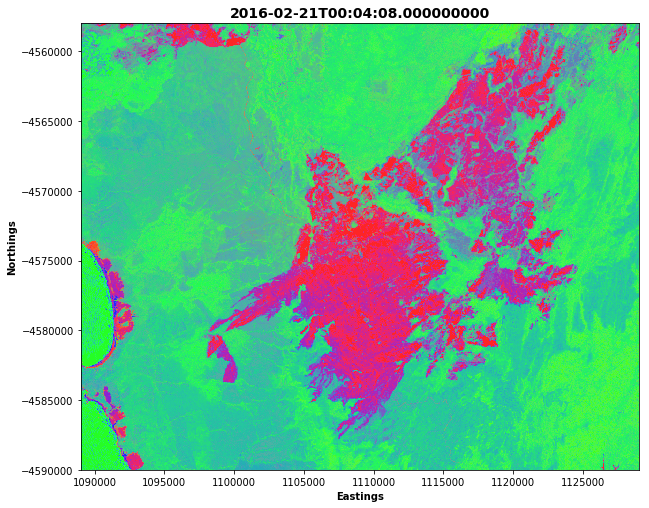

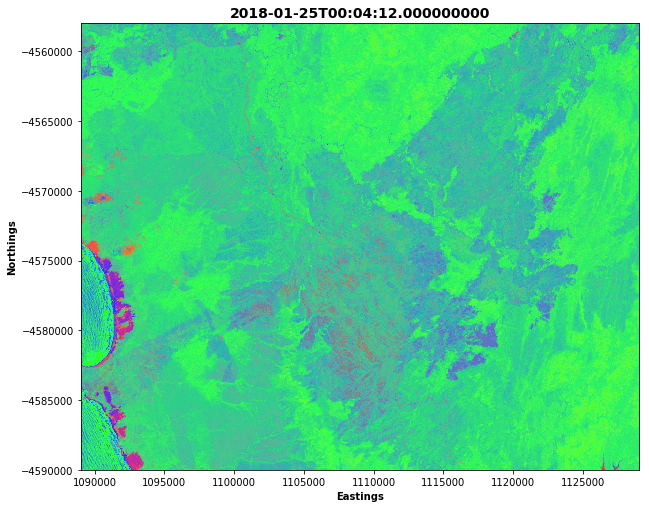

In [8]:
DEAPlotting.three_band_image(dc_data, bands = ['BS', 'PV', 'NPV'], contrast_enhance=True);
DEAPlotting.three_band_image(dc_data2, bands = ['BS', 'PV', 'NPV'], contrast_enhance=True);

In [9]:
ds_comb = xr.concat([dc_data, dc_data2], dim='time')
ds_comb

<xarray.Dataset>
Dimensions:  (time: 2, x: 1600, y: 1280)
Coordinates:
  * y        (y) float64 -4.558e+06 -4.558e+06 ... -4.59e+06 -4.59e+06
  * x        (x) float64 1.089e+06 1.089e+06 1.089e+06 ... 1.129e+06 1.129e+06
  * time     (time) datetime64[ns] 2016-02-21T00:04:08 2018-01-25T00:04:12
Data variables:
    BS       (time, y, x) int8 57 45 30 19 14 17 20 24 23 ... 0 4 4 1 0 1 6 0 1
    PV       (time, y, x) int8 0 9 21 32 37 31 30 30 ... 77 77 80 82 62 36 62 88
    NPV      (time, y, x) int8 42 45 47 48 48 51 48 44 ... 17 17 16 36 57 37 9
    UE       (time, y, x) int8 25 22 20 21 23 26 28 27 ... 34 33 32 24 19 30 32
Attributes:
    crs:      EPSG:3577

In [10]:
dc_diff = ds_comb.diff('time')
dc_diff

<xarray.Dataset>
Dimensions:  (time: 1, x: 1600, y: 1280)
Coordinates:
  * y        (y) float64 -4.558e+06 -4.558e+06 ... -4.59e+06 -4.59e+06
  * x        (x) float64 1.089e+06 1.089e+06 1.089e+06 ... 1.129e+06 1.129e+06
  * time     (time) datetime64[ns] 2018-01-25T00:04:12
Data variables:
    BS       (time, y, x) int8 -54 -43 -28 -17 -11 -17 -20 ... -5 -7 1 -5 -5 -4
    PV       (time, y, x) int8 52 46 36 28 22 29 27 23 30 ... -4 2 4 6 1 0 -6 5
    NPV      (time, y, x) int8 2 -3 -7 -11 -12 -12 -6 0 ... 1 -3 1 0 -2 5 11 -2
    UE       (time, y, x) int8 -3 1 3 1 0 -1 0 1 0 ... -2 -2 -2 -2 -4 -3 -1 -1
Attributes:
    crs:      EPSG:3577

In [11]:
dc_diff

<xarray.Dataset>
Dimensions:  (time: 1, x: 1600, y: 1280)
Coordinates:
  * y        (y) float64 -4.558e+06 -4.558e+06 ... -4.59e+06 -4.59e+06
  * x        (x) float64 1.089e+06 1.089e+06 1.089e+06 ... 1.129e+06 1.129e+06
  * time     (time) datetime64[ns] 2018-01-25T00:04:12
Data variables:
    BS       (time, y, x) int8 -54 -43 -28 -17 -11 -17 -20 ... -5 -7 1 -5 -5 -4
    PV       (time, y, x) int8 52 46 36 28 22 29 27 23 30 ... -4 2 4 6 1 0 -6 5
    NPV      (time, y, x) int8 2 -3 -7 -11 -12 -12 -6 0 ... 1 -3 1 0 -2 5 11 -2
    UE       (time, y, x) int8 -3 1 3 1 0 -1 0 1 0 ... -2 -2 -2 -2 -4 -3 -1 -1
Attributes:
    crs:      EPSG:3577

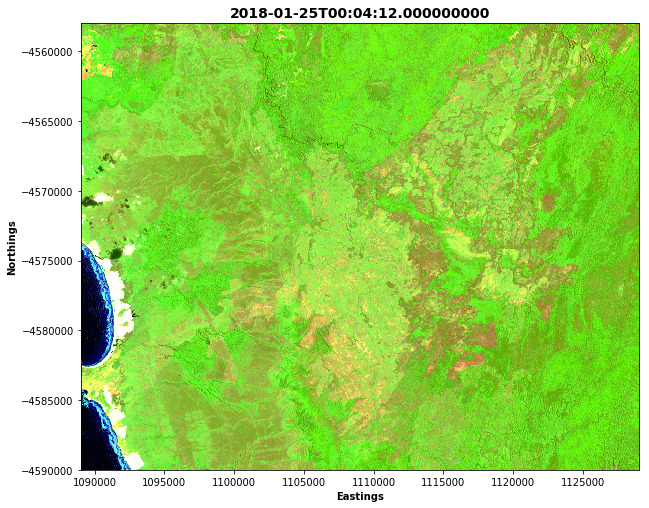

In [36]:
DEAPlotting.three_band_image(dc_data2, bands = ['swir1', 'nir', 'green'], contrast_enhance=True);

In [41]:
#DEADataHandling.dataset_to_geotiff('PIPELINE_ls8_nbart_20160221.tif', dc_data.isel(time=0))
datacube.helpers.write_geotiff(filename='PIPELINE_ls8_nbart_20160221.tif', dataset=dc_data.isel(time=0))
#dc_data
#datacube.storage.storage.write_dataset_to_netcdf(dc_diff, 'PIPELINE_ls8_fc_20180125_20160221_diff.nc')